# BART for Prediction and Causal Inference
**625.726 Final Project**

**Jeremy Lee**

This notebook implements BART models for inference on a used car dataset as
described in my final project report.

### Libraries

In [7]:
library(bartCause)
library(dbarts)
library(reshape2)
library(rsample)
library(tidyverse)

### Load and Preprocess Data

In [8]:
# Data must be stored in the working directory as "vehicles.csv"
data <- read_csv("vehicles.csv") %>%
  select(price,
         year,
         manufacturer,
         fuel,
         odometer,
         title_status,
         transmission,
         paint_color,
         state,
         lat,
         long) %>%
  # Remove missing values, outliers, unique values and encode categorical variables
  na.omit() %>%
  filter(price > 1000, odometer > 1000) %>%
  filter(across(where(is.numeric), ~ . >= quantile(., 0.25) - 1.5 * IQR(.) &
                  . <= quantile(., 0.75) + 1.5 * IQR(.))) %>%
  filter(across(where(is.character), ~ duplicated(.)
                | duplicated(., fromLast = TRUE))) %>%
  mutate(across(where(is.character), as.factor))

Rows: 426880 Columns: 26
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (18): url, region, region_url, manufacturer, model, condition, cylinder...
dbl   (6): id, price, year, odometer, lat, long
lgl   (1): county
dttm  (1): posting_date

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Warning message:
“Using `across()` in `filter()` was deprecated in dplyr 1.0.8.
ℹ Please use `if_any()` or `if_all()` instead.”
Warning message:
“Using `across()` in `filter()` was deprecated in dplyr 1.0.8.
ℹ Please use `if_any()` or `if_all()` instead.”


In [9]:
# Check the data
head(data)
glimpse(data)
summary(data)

price,year,manufacturer,fuel,odometer,title_status,transmission,paint_color,state,lat,long
<dbl>,<dbl>,<fct>,<fct>,<dbl>,<fct>,<fct>,<fct>,<fct>,<dbl>,<dbl>
33590,2014,gmc,gas,57923,clean,other,white,al,32.590,-85.4800
22590,2010,chevrolet,gas,71229,clean,other,blue,al,32.590,-85.4800
39590,2020,chevrolet,gas,19160,clean,other,red,al,32.590,-85.4800
30990,2017,toyota,gas,41124,clean,other,red,al,32.590,-85.4800
15000,2013,ford,gas,128000,clean,automatic,black,al,32.592,-85.5189
27990,2012,gmc,gas,68696,clean,other,black,al,32.590,-85.4800


Rows: 231,475
Columns: 11
$ price        <dbl> 33590, 22590, 39590, 30990, 15000, 27990, 34590, 35000, 2…
$ year         <dbl> 2014, 2010, 2020, 2017, 2013, 2012, 2016, 2019, 2016, 201…
$ manufacturer <fct> gmc, chevrolet, chevrolet, toyota, ford, gmc, chevrolet, …
$ fuel         <fct> gas, gas, gas, gas, gas, gas, gas, gas, gas, gas, gas, ga…
$ odometer     <dbl> 57923, 71229, 19160, 41124, 128000, 68696, 29499, 43000, …
$ title_status <fct> clean, clean, clean, clean, clean, clean, clean, clean, c…
$ transmission <fct> other, other, other, other, automatic, other, other, auto…
$ paint_color  <fct> white, blue, red, red, black, black, silver, grey, red, r…
$ state        <fct> al, al, al, al, al, al, al, al, al, al, al, al, al, al, a…
$ lat          <dbl> 32.5900, 32.5900, 32.5900, 32.5900, 32.5920, 32.5900, 32.…
$ long         <dbl> -85.48000, -85.48000, -85.48000, -85.48000, -85.51890, -8…


     price            year         manufacturer          fuel       
 Min.   : 1012   Min.   :1995   ford     : 38925   diesel  : 10973  
 1st Qu.: 8450   1st Qu.:2009   chevrolet: 29281   electric:   996  
 Median :16500   Median :2014   toyota   : 20375   gas     :197341  
 Mean   :18945   Mean   :2013   honda    : 12819   hybrid  :  3162  
 3rd Qu.:27990   3rd Qu.:2017   nissan   : 11175   other   : 19003  
 Max.   :57500   Max.   :2022   jeep     : 10399                    
                                (Other)  :108501                    
    odometer          title_status       transmission     paint_color   
 Min.   :  1001   clean     :223194   automatic:175497   white  :60208  
 1st Qu.: 39649   lien      :  1042   manual   : 10586   black  :50623  
 Median : 87876   missing   :    77   other    : 45392   silver :35123  
 Mean   : 91987   parts only:    27                      blue   :24673  
 3rd Qu.:134120   rebuilt   :  4862                      red    :23151  
 Max.   :2

In [10]:
# Split the data into training and test sets
set.seed(0)
split <- initial_split(data, prop = 0.8)
train_data <- training(split)
test_data <- testing(split)

### Exploratory Data Analysis

In [11]:
# Check the training data
head(train_data)
glimpse(train_data)
summary(train_data)

price,year,manufacturer,fuel,odometer,title_status,transmission,paint_color,state,lat,long
<dbl>,<dbl>,<fct>,<fct>,<dbl>,<fct>,<fct>,<fct>,<fct>,<dbl>,<dbl>
8995,2010,jeep,gas,101000,clean,automatic,white,in,41.68033,-86.16138
28188,2015,jeep,gas,98516,clean,automatic,black,ca,34.07042,-117.38334
3995,2005,ford,gas,149000,clean,automatic,red,fl,30.37596,-84.29253
12990,2014,ford,gas,109263,clean,automatic,red,or,44.08306,-123.15302
3950,2003,toyota,gas,212660,clean,automatic,white,il,38.48007,-90.44246
5000,2008,chrysler,gas,176000,clean,automatic,red,pa,40.27765,-77.81966


Rows: 185,180
Columns: 11
$ price        <dbl> 8995, 28188, 3995, 12990, 3950, 5000, 38590, 24000, 20590…
$ year         <dbl> 2010, 2015, 2005, 2014, 2003, 2008, 2015, 2018, 2015, 201…
$ manufacturer <fct> jeep, jeep, ford, ford, toyota, chrysler, ford, kia, volk…
$ fuel         <fct> gas, gas, gas, gas, gas, gas, other, electric, gas, gas, …
$ odometer     <dbl> 101000, 98516, 149000, 109263, 212660, 176000, 41804, 251…
$ title_status <fct> clean, clean, clean, clean, clean, clean, clean, clean, c…
$ transmission <fct> automatic, automatic, automatic, automatic, automatic, au…
$ paint_color  <fct> white, black, red, red, white, red, brown, blue, black, b…
$ state        <fct> in, ca, fl, or, il, pa, fl, mi, ks, tn, or, ca, al, fl, m…
$ lat          <dbl> 41.68033, 34.07042, 30.37596, 44.08306, 38.48007, 40.2776…
$ long         <dbl> -86.16138, -117.38334, -84.29253, -123.15302, -90.44246, …


     price            year         manufacturer         fuel       
 Min.   : 1012   Min.   :1995   ford     :31179   diesel  :  8890  
 1st Qu.: 8486   1st Qu.:2009   chevrolet:23431   electric:   803  
 Median :16500   Median :2014   toyota   :16217   gas     :157793  
 Mean   :18965   Mean   :2013   honda    :10259   hybrid  :  2542  
 3rd Qu.:27990   3rd Qu.:2017   nissan   : 8978   other   : 15152  
 Max.   :57500   Max.   :2022   jeep     : 8379                    
                                (Other)  :86737                    
    odometer          title_status       transmission     paint_color   
 Min.   :  1001   clean     :178569   automatic:140224   white  :48260  
 1st Qu.: 39649   lien      :   841   manual   :  8532   black  :40452  
 Median : 87841   missing   :    53   other    : 36424   silver :28058  
 Mean   : 91946   parts only:    21                      blue   :19690  
 3rd Qu.:134000   rebuilt   :  3879                      red    :18568  
 Max.   :276865   

##### Histograms

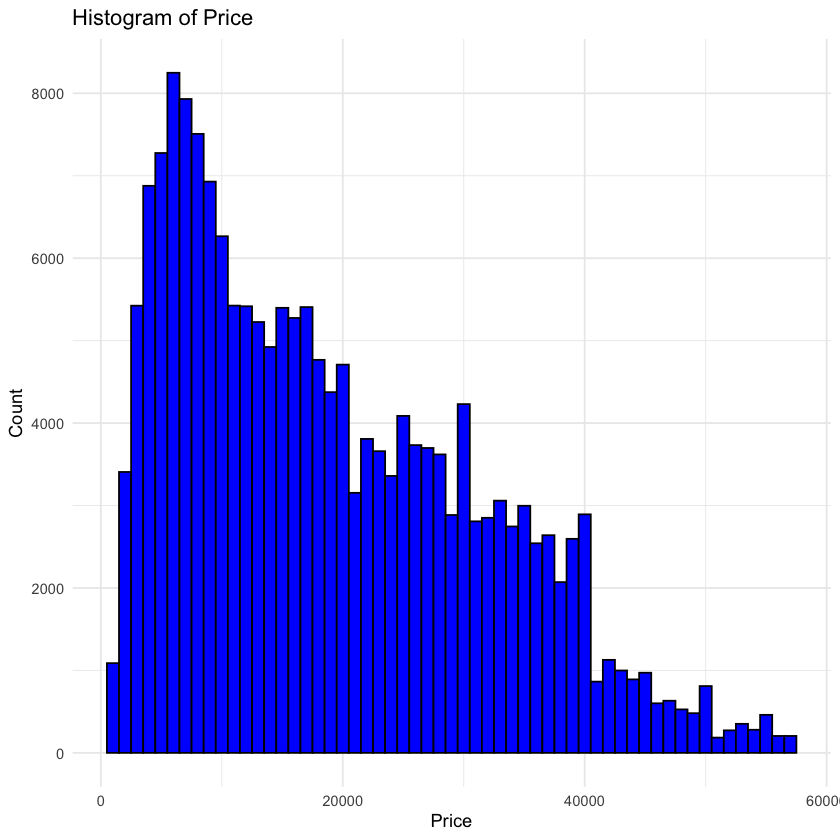

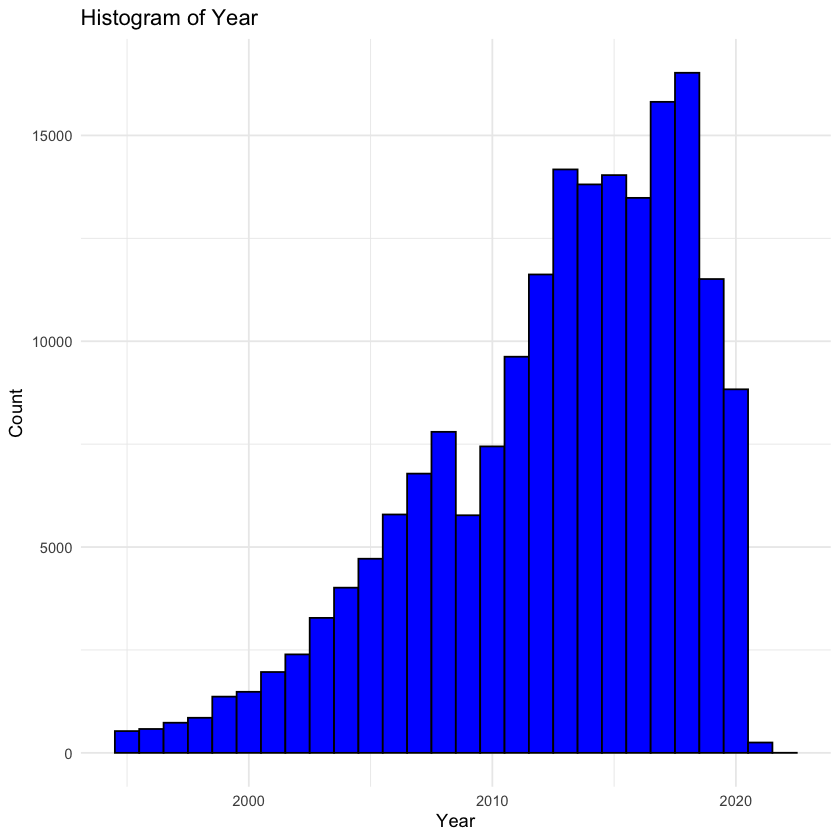

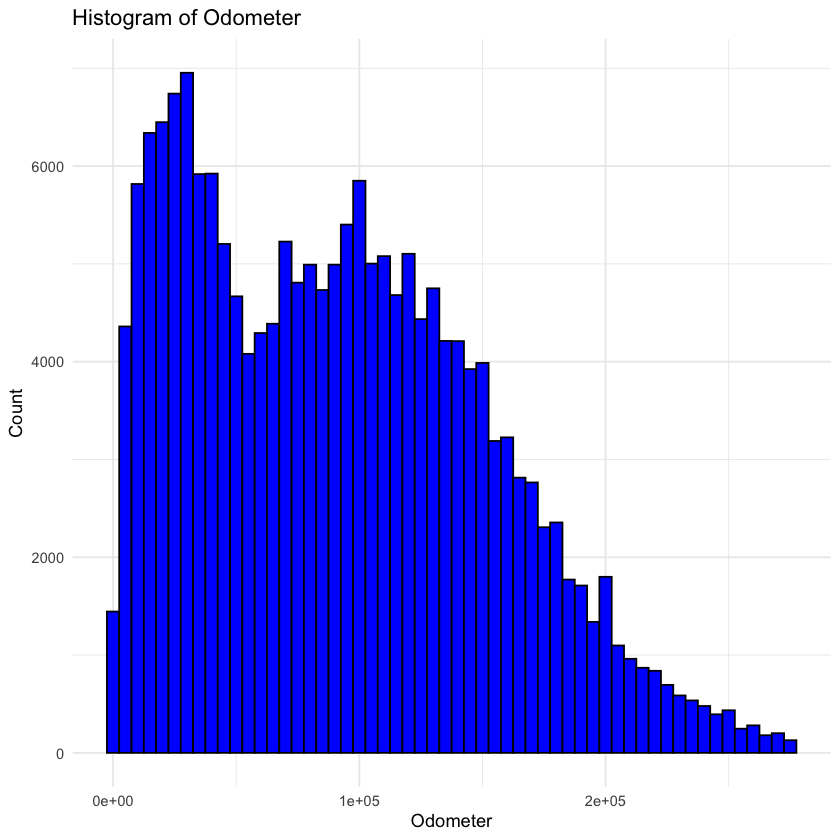

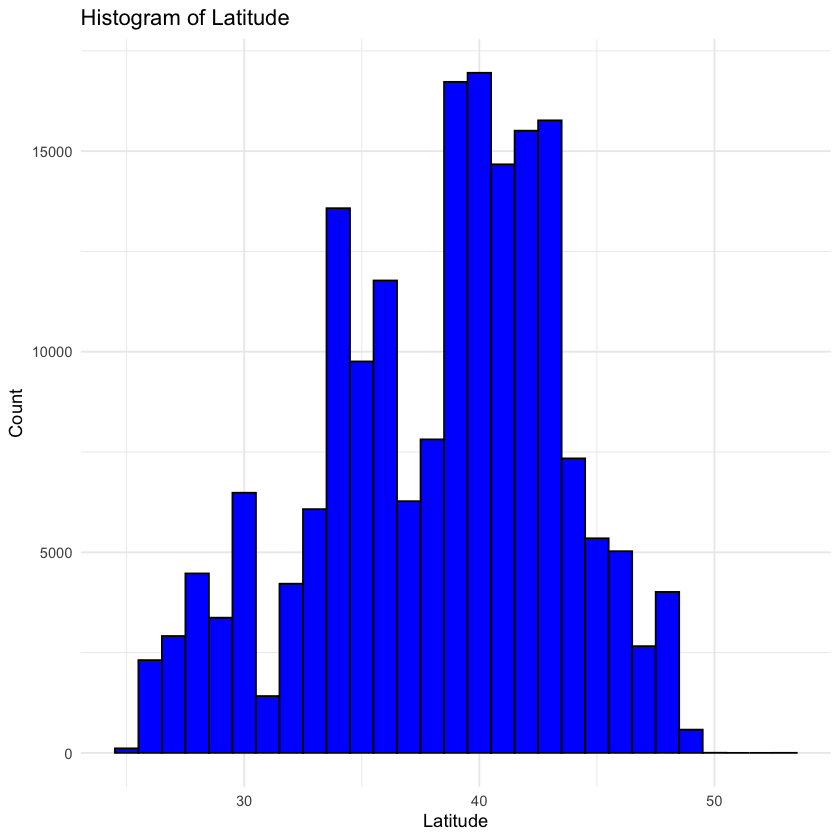

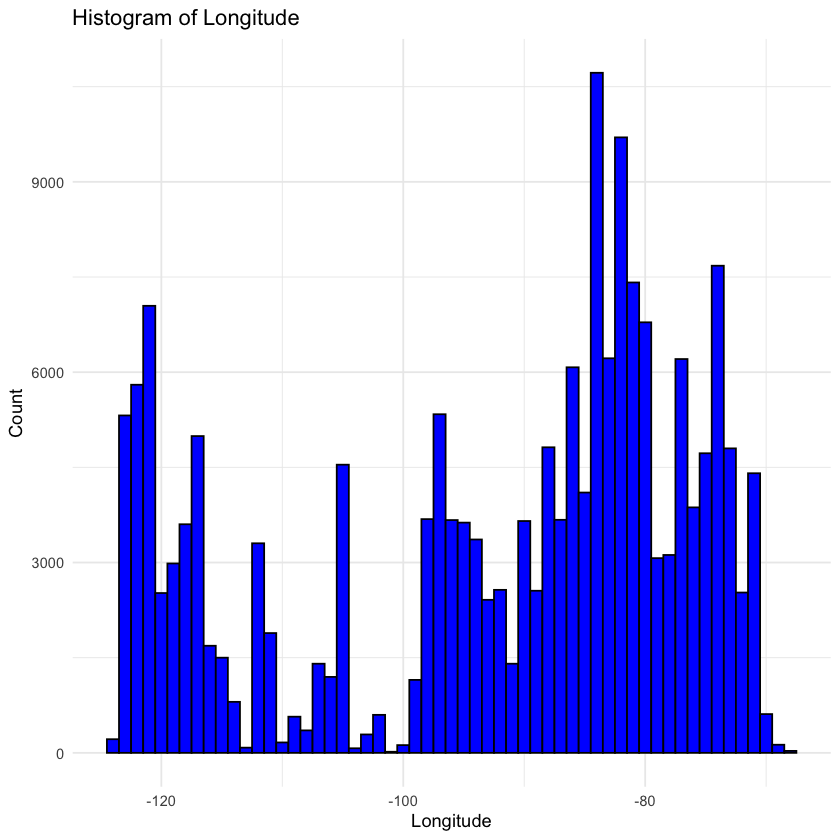

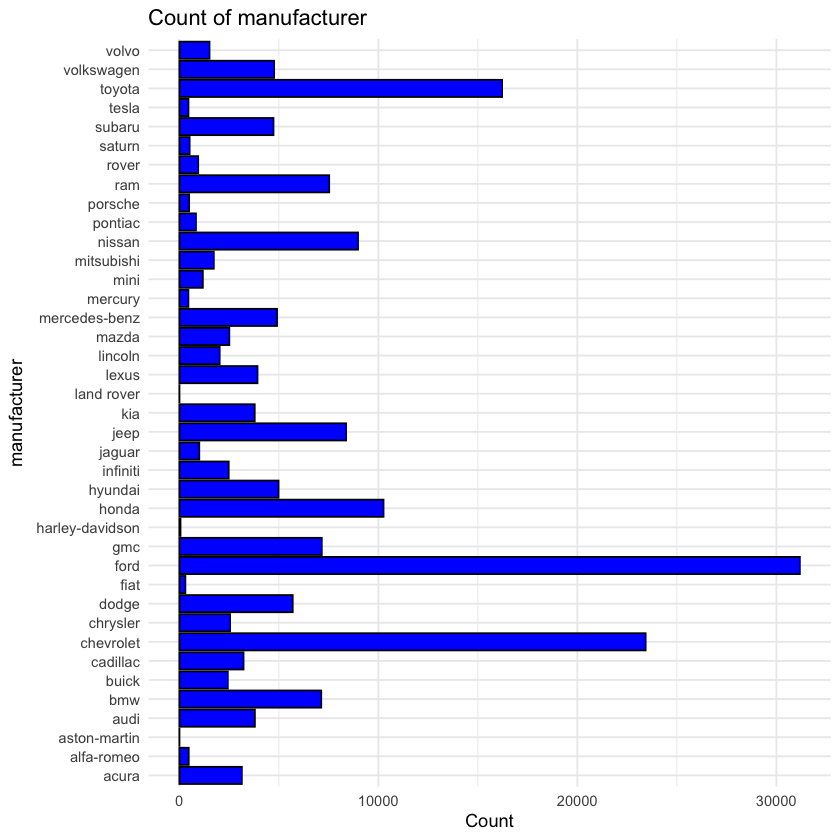

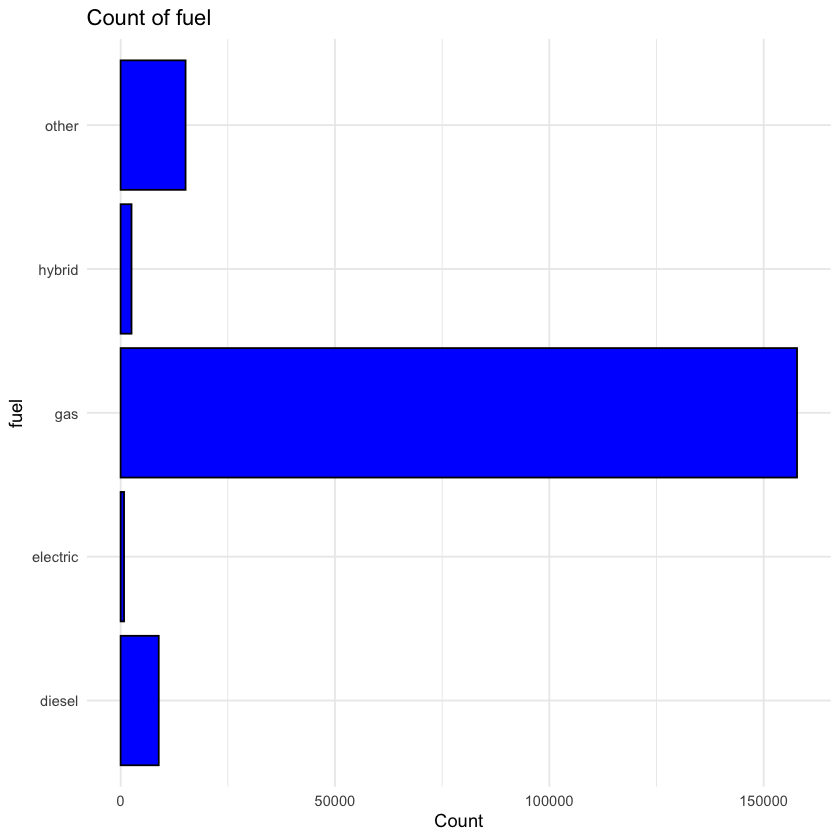

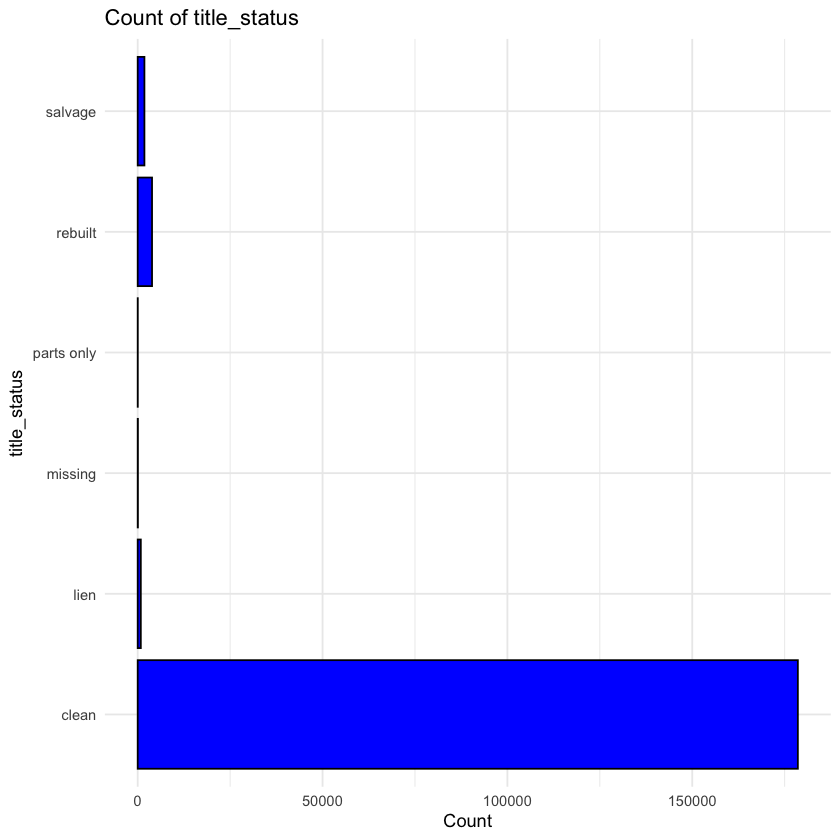

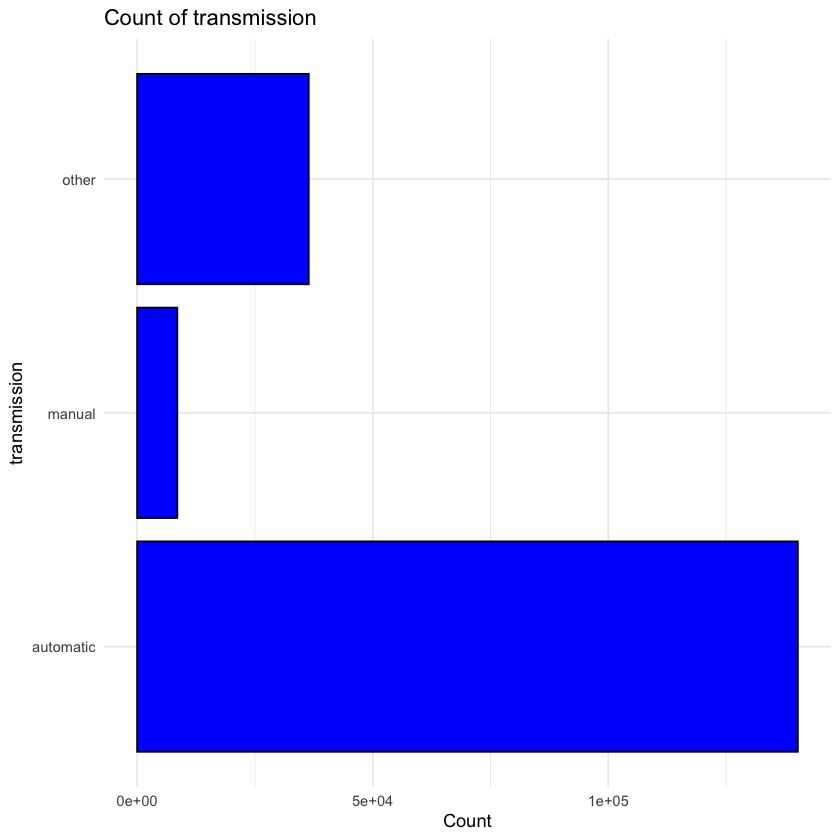

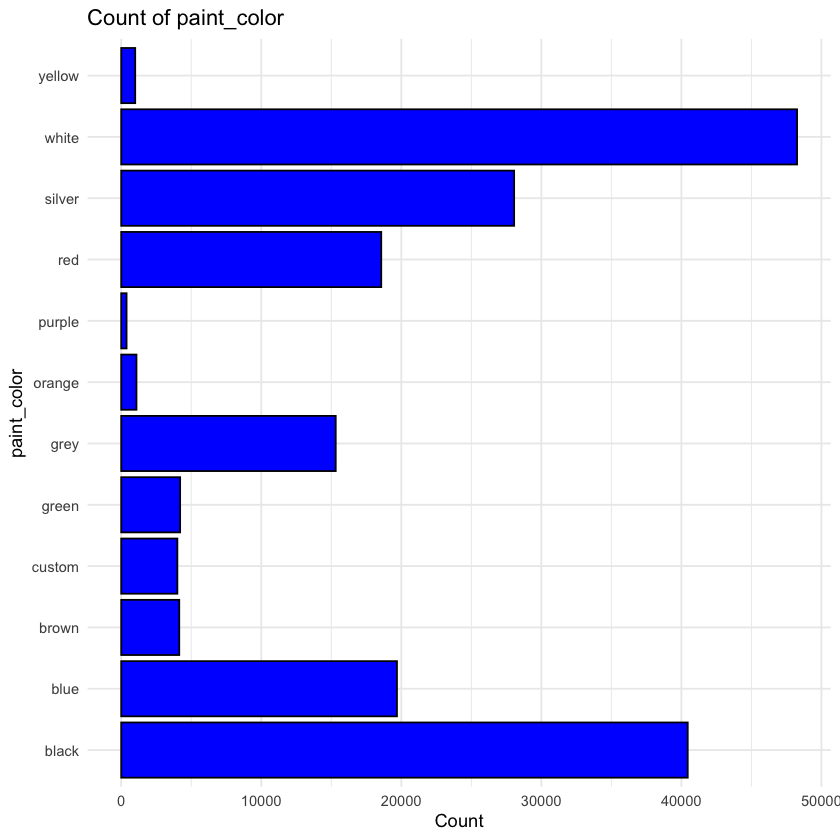

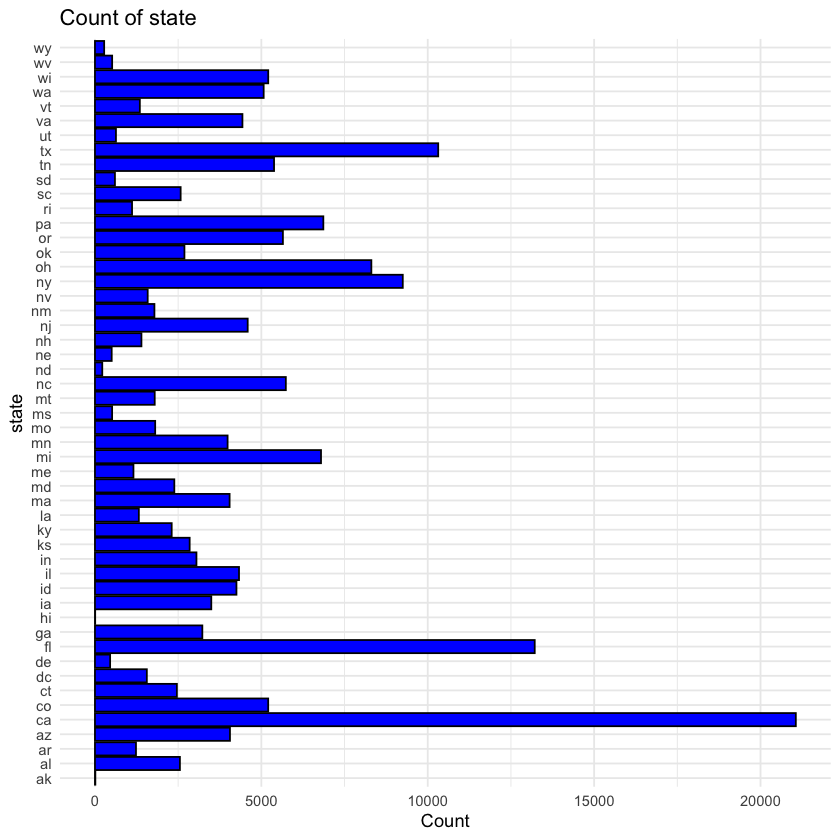

In [12]:
# Plot the distributions of the features
p <- ggplot(train_data, aes(x = price)) +
  geom_histogram(binwidth = 1000, fill = "blue", color = "black") +
  labs(title = "Histogram of Price", x = "Price", y = "Count") +
  theme_minimal()
print(p)
p <- ggplot(train_data, aes(x = year)) +
  geom_histogram(binwidth = 1, fill = "blue", color = "black") +
  labs(title = "Histogram of Year", x = "Year", y = "Count") +
  theme_minimal()
print(p)
p <- ggplot(train_data, aes(x = odometer)) +
  geom_histogram(binwidth = 5000, fill = "blue", color = "black") +
  labs(title = "Histogram of Odometer", x = "Odometer", y = "Count") +
  theme_minimal()
print(p)
p <- ggplot(train_data, aes(x = lat)) +
  geom_histogram(binwidth = 1, fill = "blue", color = "black") +
  labs(title = "Histogram of Latitude", x = "Latitude", y = "Count") +
  theme_minimal()
print(p)
p <- ggplot(train_data, aes(x = long)) +
  geom_histogram(binwidth = 1, fill = "blue", color = "black") +
  labs(title = "Histogram of Longitude", x = "Longitude", y = "Count") +
  theme_minimal()
print(p)
for (i in seq_len(ncol(train_data))) {
  column_name <- names(train_data)[i]
  if (is.factor(train_data[[i]])) {
    # Create a bar plot for character columns
    p <- ggplot(train_data, aes(x = .data[[column_name]])) +
      geom_bar(fill = "blue", color = "black") +
      labs(title = paste("Count of", column_name), x = column_name, y = "Count") +
      theme_minimal() +
      coord_flip()
    print(p)
  }
}

##### Correlations

In [13]:
# Check the correlation between numeric features
cor(data %>% select_if(is.numeric), use = "complete.obs")

,price,year,odometer,lat,long
price,1.00000000,0.63892220,-0.61732131,-0.02363394,-0.04792492
year,0.63892220,1.00000000,-0.68338005,-0.05691805,0.01956767
odometer,-0.61732131,-0.68338005,1.00000000,0.04984524,-0.02157085
lat,-0.02363394,-0.05691805,0.04984524,1.00000000,-0.08122306
long,-0.04792492,0.01956767,-0.02157085,-0.08122306,1.00000000


### Prediction

In [14]:
# Train linear regression and BART to predict the price
set.seed(0)
linear_model <- lm(price ~ ., train_data)
bart_model <- bart2(price ~ ., train_data, test_data,
  keepTrees = TRUE,
  seed = 0
)


Running BART with numeric y

number of trees: 75
number of chains: 4, default number of threads 4
tree thinning rate: 1
Prior:
	k prior fixed to 2.000000
	degrees of freedom in sigma prior: 3.000000
	quantile in sigma prior: 0.900000
	scale in sigma prior: 0.003105
	power and base for tree prior: 2.000000 0.950000
	use quantiles for rule cut points: false
	proposal probabilities: birth/death 0.50, swap 0.10, change 0.40; birth 0.50
data:
	number of training observations: 185180
	number of test observations: 46295
	number of explanatory variables: 120
	init sigma: 7131.814565, curr sigma: 7131.814565

Cutoff rules c in x<=c vs x>c
Number of cutoffs: (var: number of possible c):
(1: 100) (2: 100) (3: 100) (4: 100) (5: 100) 
(6: 100) (7: 100) (8: 100) (9: 100) (10: 100) 
(11: 100) (12: 100) (13: 100) (14: 100) (15: 100) 
(16: 100) (17: 100) (18: 100) (19: 100) (20: 100) 
(21: 100) (22: 100) (23: 100) (24: 100) (25: 100) 
(26: 100) (27: 100) (28: 100) (29: 100) (30: 100) 
(31: 100) (32: 1

In [15]:
# Compute predictions
linear_predictions <- predict(linear_model, test_data)
bart_predictions <- bart_model$yhat.test.mean
# Compute the RMSE for both models
linear_rmse <- sqrt(mean((linear_predictions - test_data$price)^2))
bart_rmse <- sqrt(mean((bart_predictions - test_data$price)^2))
print(paste("Linear RMSE:", linear_rmse))
print(paste("BART RMSE:", bart_rmse))
# Compute the MAE for both models
linear_mae <- mean(abs(linear_predictions - test_data$price))
bart_mae <- mean(abs(bart_predictions - test_data$price))
print(paste("Linear MAE:", linear_mae))
print(paste("BART MAE:", bart_mae))
# Compute the R^2 for both models
linear_r2 <- 1 - sum((linear_predictions - test_data$price)^2) / sum((test_data$price - mean(test_data$price))^2)
bart_r2 <- 1 - sum((bart_predictions - test_data$price)^2) / sum((test_data$price - mean(test_data$price))^2)
print(paste("Linear R²:", linear_r2))
print(paste("BART R²:", bart_r2))

[1] "Linear RMSE: 7119.70243567861"
[1] "BART RMSE: 6090.34429381908"
[1] "Linear MAE: 5456.27915262628"
[1] "BART MAE: 4451.75767920455"
[1] "Linear R²: 0.666506329931972"
[1] "BART R²: 0.755967539793665"


In [16]:
# Check the feature importances for both models
summary(linear_model)
variable_counts <- apply(bart_model$varcount, c(2, 3), sum)
print(sort(colMeans(variable_counts), TRUE))


Call:
lm(formula = price ~ ., data = train_data)

Residuals:
   Min     1Q Median     3Q    Max 
-49948  -4610   -559   4015  50429 

Coefficients:
                              Estimate Std. Error  t value Pr(>|t|)    
(Intercept)                 -1.785e+06  9.230e+03 -193.360  < 2e-16 ***
year                         9.054e+02  4.462e+00  202.907  < 2e-16 ***
manufactureralfa-romeo      -7.812e+02  3.535e+02   -2.210 0.027101 *  
manufactureraston-martin     3.023e+04  3.193e+03    9.469  < 2e-16 ***
manufactureraudi             1.703e+03  1.725e+02    9.874  < 2e-16 ***
manufacturerbmw              1.248e+03  1.535e+02    8.128 4.37e-16 ***
manufacturerbuick           -3.824e+03  1.931e+02  -19.807  < 2e-16 ***
manufacturercadillac         1.119e+03  1.791e+02    6.245 4.24e-10 ***
manufacturerchevrolet        1.711e+03  1.365e+02   12.531  < 2e-16 ***
manufacturerchrysler        -5.184e+03  1.911e+02  -27.135  < 2e-16 ***
manufacturerdodge           -1.889e+03  1.594e+02  -11.847 

                        year                     odometer 
                     127.432                      115.308 
                 fuel.diesel                          lat 
                      74.220                       69.576 
                        long       transmission.automatic 
                      68.490                       67.864 
          transmission.other                     fuel.gas 
                      66.322                       64.214 
      manufacturer.chevrolet            manufacturer.ford 
                      54.992                       51.746 
                  fuel.other             manufacturer.bmw 
                      51.552                       45.168 
          manufacturer.dodge            paint_color.white 
                      44.176                       38.690 
                    state.wa          transmission.manual 
                      38.580                       37.854 
                 fuel.hybrid             manufacturer.gm

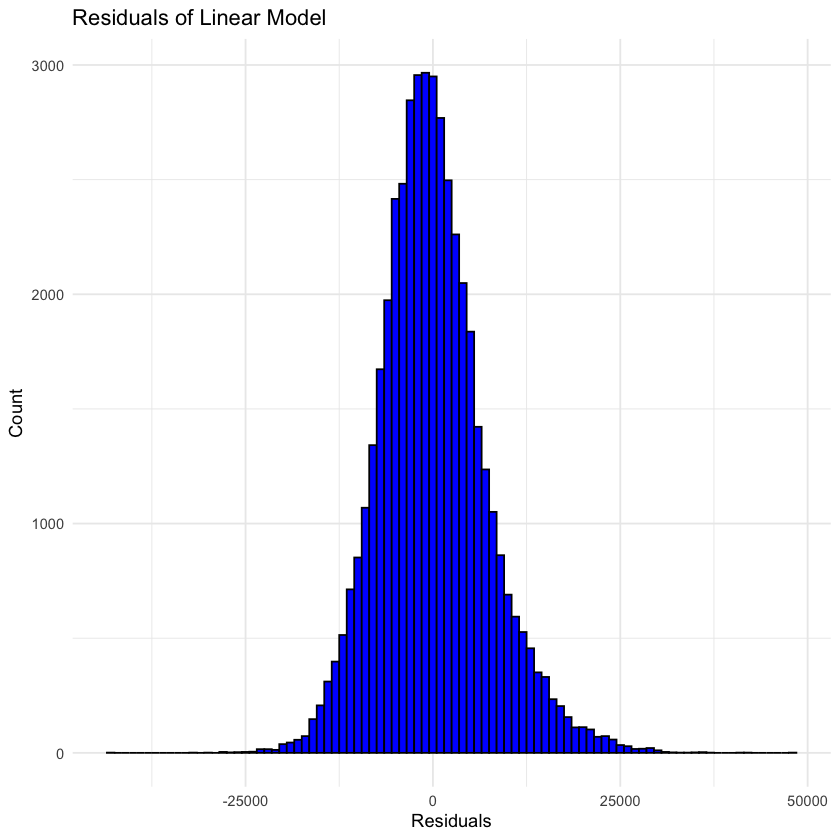

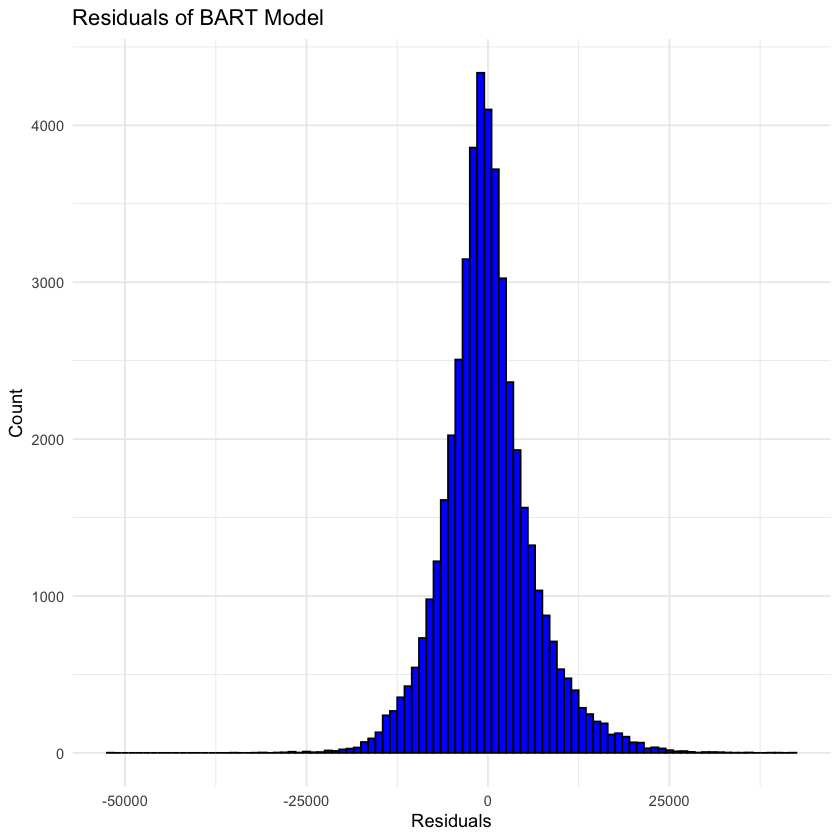

In [17]:
# Plot the residuals of both models
linear_residuals <- test_data$price - linear_predictions
ggplot(data.frame(linear_residuals), aes(x = linear_residuals)) +
  geom_histogram(binwidth = 1000, fill = "blue", color = "black") +
  labs(title = "Residuals of Linear Model", x = "Residuals", y = "Count") +
  theme_minimal()
bart_residuals <- test_data$price - bart_predictions
ggplot(data.frame(bart_residuals), aes(x = bart_residuals)) +
  geom_histogram(binwidth = 1000, fill = "blue", color = "black") +
  labs(title = "Residuals of BART Model", x = "Residuals", y = "Count") +
  theme_minimal()

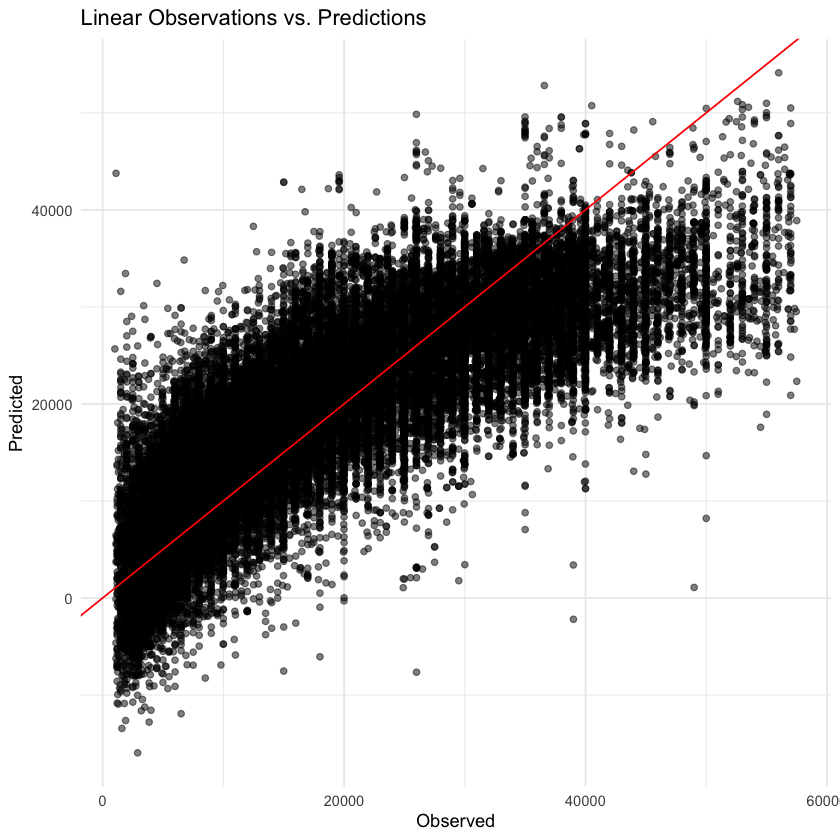

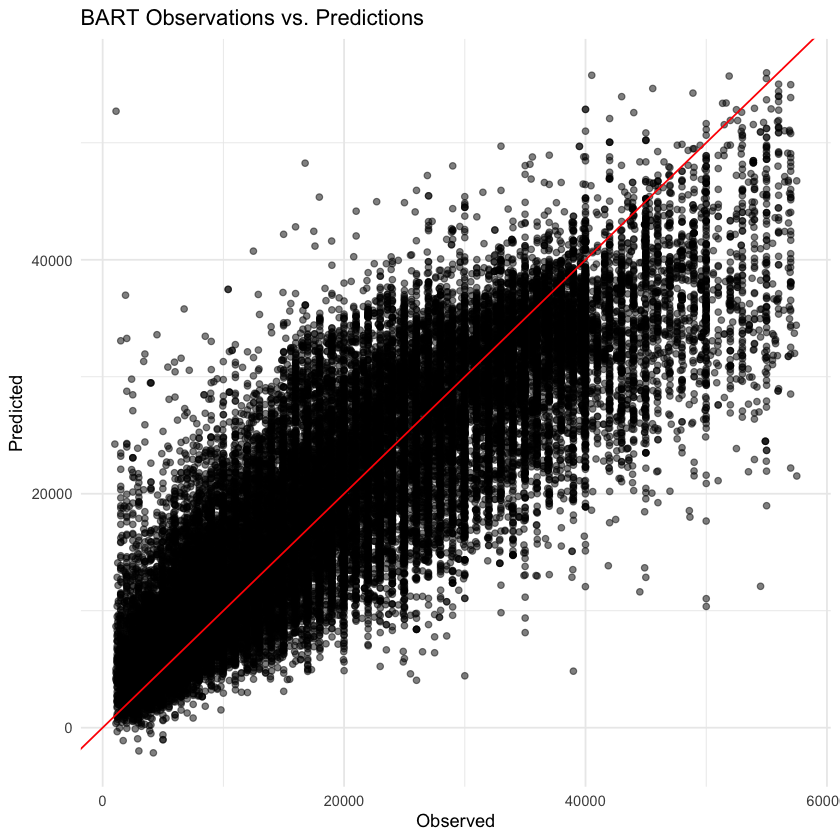

In [18]:
# Plot the predicted vs. observed values for both models
ggplot(data.frame(observed = test_data$price, predicted = linear_predictions),
       aes(x = observed, y = predicted)) +
  geom_point(alpha = 0.5) +
  geom_abline(slope = 1, intercept = 0, color = "red") +
  labs(title = "Linear Observations vs. Predictions",
       x = "Observed", y = "Predicted") +
  theme_minimal()
ggplot(data.frame(observed = test_data$price, predicted = bart_predictions),
       aes(x = observed, y = predicted)) +
  geom_point(alpha = 0.5) +
  geom_abline(slope = 1, intercept = 0, color = "red") +
  labs(title = "BART Observations vs. Predictions",
       x = "Observed", y = "Predicted") +
  theme_minimal()

### Causal Inference – Counterfactual Model

In [19]:
# First use BART for predictions on counterfactual data
bart_predictions_plus <- colMeans(predict(bart_model,
  test_data %>% mutate(odometer = odometer + 10000),
  n.samples = 1000
))
# Compute the average causal effect of 10,000 miles on price
causal_effect <- bart_predictions_plus - bart_predictions
mean_causal_effect <- mean(causal_effect)
print(paste(
  "Linear Causal Effect of 10,000 miles on Price:",
  coef(linear_model)["odometer"] * 10000
))
print(paste("BART Causal Effect of 10,000 miles on Price:", mean_causal_effect))


[1] "Linear Causal Effect of 10,000 miles on Price: -695.405587956744"
[1] "BART Causal Effect of 10,000 miles on Price: -558.589426744818"


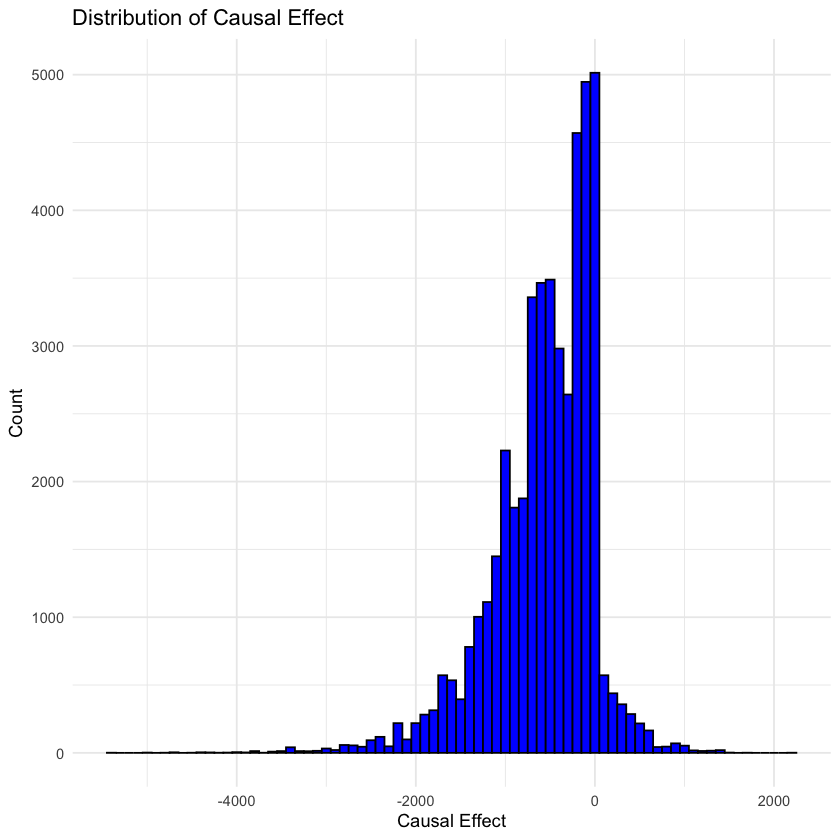

In [20]:
# Plot the distribution of the causal effect
ggplot(data.frame(causal_effect = causal_effect), aes(x = causal_effect)) +
  geom_histogram(binwidth = 100, fill = "blue", color = "black") +
  labs(title = "Distribution of Causal Effect", x = "Causal Effect", y = "Count") +
  theme_minimal()


### Causal Inference – Binary Treatment Model

In [21]:
# Create limited datasets for binary treatment causal inference
ca_data <- train_data %>% filter(manufacturer == "ford", state == "ca")
ca_data <- ca_data %>% mutate(odometer_over_100k = ifelse(odometer > 100000, 1, 0))
fl_data <- train_data %>% filter(manufacturer == "ford", state == "fl")
fl_data <- fl_data %>% mutate(odometer_over_100k = ifelse(odometer > 100000, 1, 0))
tx_data <- train_data %>% filter(manufacturer == "ford", state == "tx")
tx_data <- tx_data %>% mutate(odometer_over_100k = ifelse(odometer > 100000, 1, 0))
glimpse(ca_data)
glimpse(fl_data)
glimpse(tx_data)

Rows: 2,954
Columns: 12
$ price              <dbl> 14995, 46991, 13995, 34995, 12899, 11671, 5000, 139…
$ year               <dbl> 2013, 2016, 2013, 2015, 2015, 2014, 2009, 2017, 200…
$ manufacturer       <fct> ford, ford, ford, ford, ford, ford, ford, ford, for…
$ fuel               <fct> gas, diesel, gas, other, gas, gas, gas, gas, gas, o…
$ odometer           <dbl> 76640, 87291, 41536, 113247, 113828, 102829, 126000…
$ title_status       <fct> clean, clean, clean, clean, clean, clean, clean, cl…
$ transmission       <fct> automatic, automatic, automatic, automatic, automat…
$ paint_color        <fct> red, white, blue, white, white, silver, red, white,…
$ state              <fct> ca, ca, ca, ca, ca, ca, ca, ca, ca, ca, ca, ca, ca,…
$ lat                <dbl> 37.73824, 38.59777, 40.58633, 34.07031, 37.79714, 3…
$ long               <dbl> -120.93916, -121.40306, -122.39307, -117.44630, -12…
$ odometer_over_100k <dbl> 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, …
Rows: 2,270
Colu

In [22]:
# Train BART causal models
causal_model1 <- bartc(
  response = ca_data %>% select(price),
  treatment = ca_data %>% select(odometer_over_100k),
  confounders = ca_data %>% select(-price, -odometer, -odometer_over_100k)
)
causal_model2 <- bartc(
  response = fl_data %>% select(price),
  treatment = fl_data %>% select(odometer_over_100k),
  confounders = fl_data %>% select(-price, -odometer, -odometer_over_100k)
)
causal_model3 <- bartc(
  response = tx_data %>% select(price),
  treatment = tx_data %>% select(odometer_over_100k),
  confounders = tx_data %>% select(-price, -odometer, -odometer_over_100k)
)

fitting treatment model via method 'bart'
fitting response model via method 'bart'
fitting treatment model via method 'bart'
fitting response model via method 'bart'
fitting treatment model via method 'bart'
fitting response model via method 'bart'


In [23]:
# Check the results of the causal models
summary(causal_model1)
summary(causal_model2)
summary(causal_model3)

Call: bartc(response = ca_data %>% select(price), treatment = ca_data %>% 
            select(odometer_over_100k), confounders = ca_data %>% select(-price, 
            -odometer, -odometer_over_100k))

Causal inference model fit by:
  model.rsp: bart
  model.trt: bart

Treatment effect (population average):
    estimate    sd ci.lower ci.upper
ate    -5784 458.6    -6683    -4885
Estimates fit from 2954 total observations
95% credible interval calculated by: normal approximation
  population TE approximated by: posterior predictive distribution
Result based on 500 posterior samples times 10 chains

Call: bartc(response = fl_data %>% select(price), treatment = fl_data %>% 
            select(odometer_over_100k), confounders = fl_data %>% select(-price, 
            -odometer, -odometer_over_100k))

Causal inference model fit by:
  model.rsp: bart
  model.trt: bart

Treatment effect (population average):
    estimate    sd ci.lower ci.upper
ate    -4782 719.7    -6193    -3372
Estimates fit from 2270 total observations
95% credible interval calculated by: normal approximation
  population TE approximated by: posterior predictive distribution
Result based on 500 posterior samples times 10 chains

Call: bartc(response = tx_data %>% select(price), treatment = tx_data %>% 
            select(odometer_over_100k), confounders = tx_data %>% select(-price, 
            -odometer, -odometer_over_100k))

Causal inference model fit by:
  model.rsp: bart
  model.trt: bart

Treatment effect (population average):
    estimate    sd ci.lower ci.upper
ate    -2927 662.8    -4226    -1627
Estimates fit from 1960 total observations
95% credible interval calculated by: normal approximation
  population TE approximated by: posterior predictive distribution
Result based on 500 posterior samples times 10 chains

### Cross-Validation

In [24]:
# Find optimal hyperparameters for BART using 5-fold cross-validation
errors <- xbart(price ~ ., train_data,
  method = "k-fold",
  n.test = 5,
  n.reps = 1,
  loss = "rmse",
  n.trees = c(50L, 75L, 200L),
  power = c(1.5, 2, 2.5),
  base = c(0.9, 0.95, 0.99),
  seed = 0
)

   n.trees power base     rmse
1       50   1.5 0.90 6254.553
2       75   1.5 0.90 6103.713
3      200   1.5 0.90 6041.986
4       50   2.0 0.90 6300.362
5       75   2.0 0.90 6117.570
6      200   2.0 0.90 6042.672
7       50   2.5 0.90 6323.479
8       75   2.5 0.90 6140.965
9      200   2.5 0.90 6060.727
10      50   1.5 0.95 6193.175
11      75   1.5 0.95 6035.648
12     200   1.5 0.95 6215.659
13      50   2.0 0.95 6038.423
14      75   2.0 0.95 6218.446
15     200   2.0 0.95 6048.232
16      50   2.5 0.95 6229.623
17      75   2.5 0.95 6052.673
18     200   2.5 0.95 6218.924
19      50   1.5 0.99 5999.672
20      75   1.5 0.99 6050.928
21     200   1.5 0.99 5890.930
22      50   2.0 0.99 6083.078
23      75   2.0 0.99 5925.833
24     200   2.0 0.99 6072.990
25      50   2.5 0.99 5950.404
26      75   2.5 0.99 6089.105
27     200   2.5 0.99 5969.203


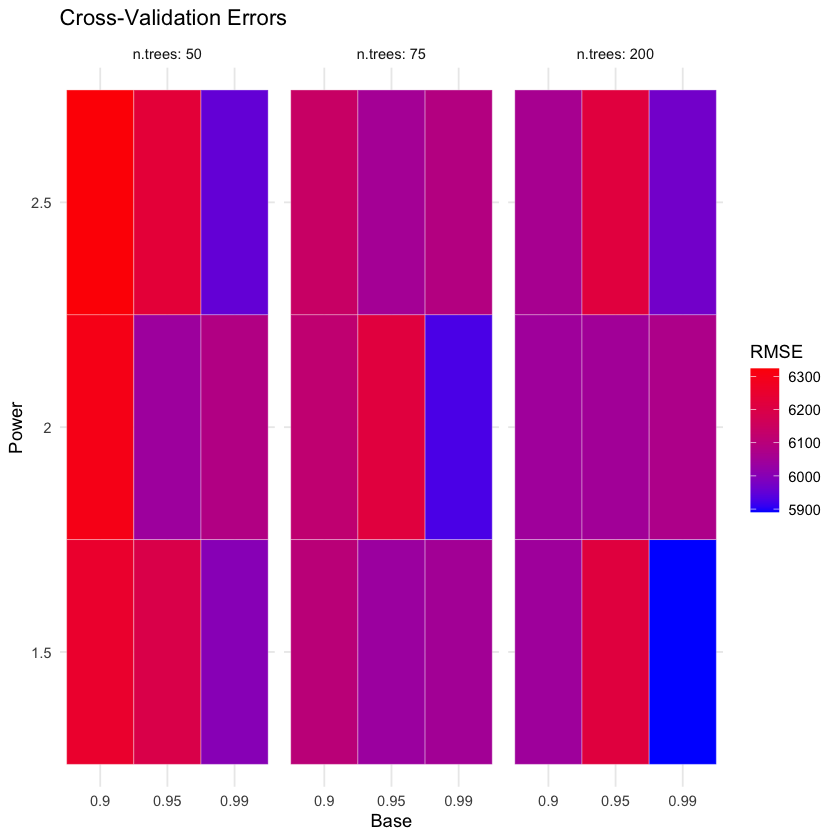

In [25]:
# Check the errors
errors_df <- as.data.frame(melt(errors, varnames = c("NA", "n.trees", "power", "base"), value.name = "rmse"))
errors_df <- errors_df[, !names(errors_df) %in% "NA"]
print(errors_df)
# Plot heatmap of the errors
ggplot(errors_df, aes(x = factor(base), y = factor(power), fill = rmse)) +
  geom_tile(color = "white") +
  facet_wrap(~ n.trees, labeller = label_both) +
  scale_fill_gradient(low = "blue", high = "red") +
  labs(
    title = "Cross-Validation Errors",
    x = "Base",
    y = "Power",
    fill = "RMSE"
  ) +
  theme_minimal()

In [26]:
# Train BART with optimal hyperparameters
xbart_model <- bart2(price ~ ., train_data, test_data,
  power = 1.5,
  base = 0.99,
  n.trees = 200L,
  keepTrees = TRUE,
  seed = 0
)


Running BART with numeric y

number of trees: 200
number of chains: 4, default number of threads 4
tree thinning rate: 1
Prior:
	k prior fixed to 2.000000
	degrees of freedom in sigma prior: 3.000000
	quantile in sigma prior: 0.900000
	scale in sigma prior: 0.003105
	power and base for tree prior: 1.500000 0.990000
	use quantiles for rule cut points: false
	proposal probabilities: birth/death 0.50, swap 0.10, change 0.40; birth 0.50
data:
	number of training observations: 185180
	number of test observations: 46295
	number of explanatory variables: 120
	init sigma: 7131.814565, curr sigma: 7131.814565

Cutoff rules c in x<=c vs x>c
Number of cutoffs: (var: number of possible c):
(1: 100) (2: 100) (3: 100) (4: 100) (5: 100) 
(6: 100) (7: 100) (8: 100) (9: 100) (10: 100) 
(11: 100) (12: 100) (13: 100) (14: 100) (15: 100) 
(16: 100) (17: 100) (18: 100) (19: 100) (20: 100) 
(21: 100) (22: 100) (23: 100) (24: 100) (25: 100) 
(26: 100) (27: 100) (28: 100) (29: 100) (30: 100) 
(31: 100) (32: 

[1] "XBART RMSE: 5952.48943575175"
[1] "XBART MAE: 4321.56446167997"
[1] "XBART R²: 0.76688985423021"
                        year                     odometer 
                     222.290                      209.748 
                         lat                  fuel.diesel 
                     145.246                      138.850 
                        long           transmission.other 
                     133.926                      128.276 
      transmission.automatic       manufacturer.chevrolet 
                     120.624                      106.256 
           manufacturer.ford                     fuel.gas 
                     103.126                      101.058 
                  fuel.other            paint_color.white 
                      95.176                       77.720 
            manufacturer.gmc          manufacturer.toyota 
                      77.452                       74.884 
            manufacturer.ram          transmission.manual 
             

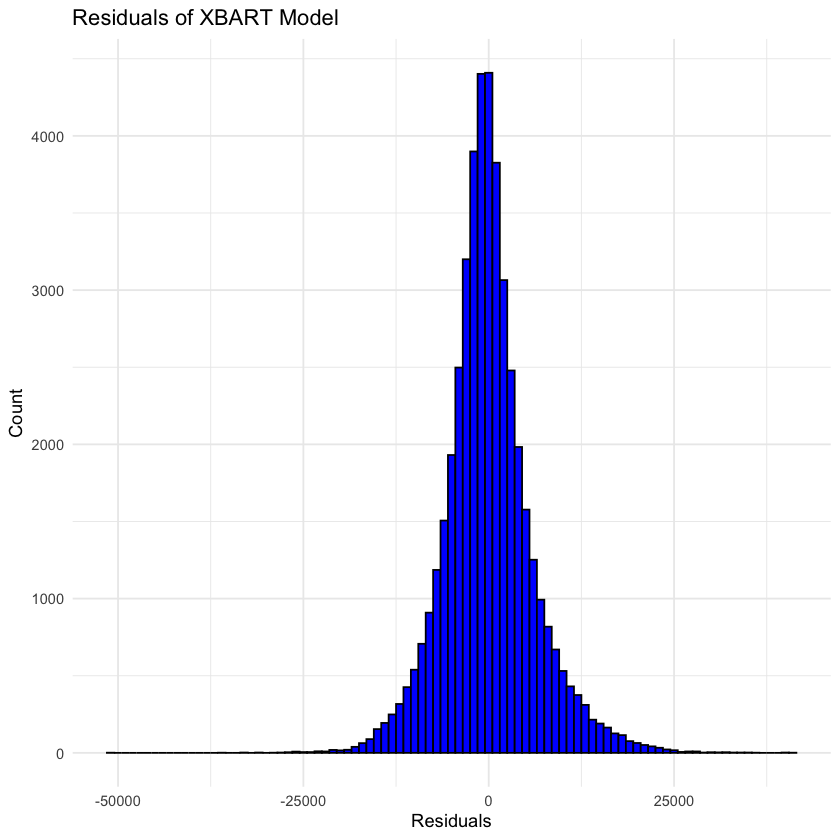

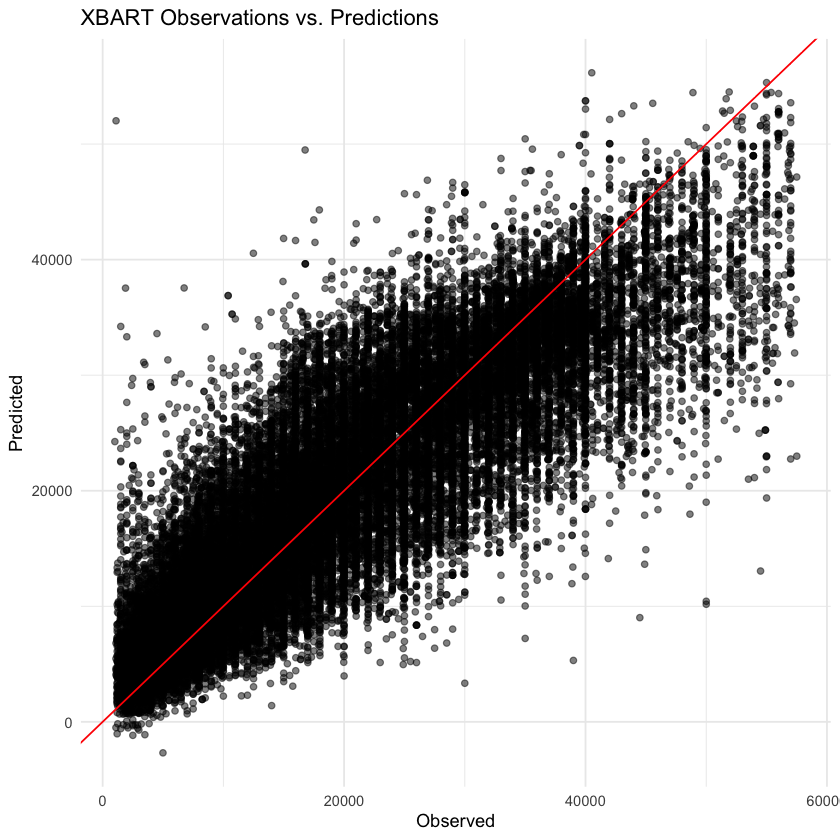

In [27]:
# Compute predictions and metrics
xbart_predictions <- xbart_model$yhat.test.mean
xbart_rmse <- sqrt(mean((xbart_predictions - test_data$price)^2))
print(paste("XBART RMSE:", xbart_rmse))
xbart_mae <- mean(abs(xbart_predictions - test_data$price))
print(paste("XBART MAE:", xbart_mae))
xbart_r2 <- 1 - sum((xbart_predictions - test_data$price)^2) / sum((test_data$price - mean(test_data$price))^2)
print(paste("XBART R²:", xbart_r2))
# Check the feature importances
xvariable_counts <- apply(xbart_model$varcount, c(2, 3), sum)
print(sort(colMeans(xvariable_counts), TRUE))
# Plot the residuals of the XBART model
xbart_residuals <- test_data$price - xbart_predictions
ggplot(data.frame(xbart_residuals), aes(x = xbart_residuals)) +
  geom_histogram(binwidth = 1000, fill = "blue", color = "black") +
  labs(title = "Residuals of XBART Model", x = "Residuals", y = "Count") +
  theme_minimal()
# Plot the predicted vs. observed values for the XBART model
ggplot(data.frame(observed = test_data$price, predicted = xbart_predictions),
       aes(x = observed, y = predicted)) +
  geom_point(alpha = 0.5) +
  geom_abline(slope = 1, intercept = 0, color = "red") +
  labs(title = "XBART Observations vs. Predictions",
       x = "Observed", y = "Predicted") +
  theme_minimal()

[1] "XBART Causal Effect of 10,000 miles on Price: -549.469634209984"


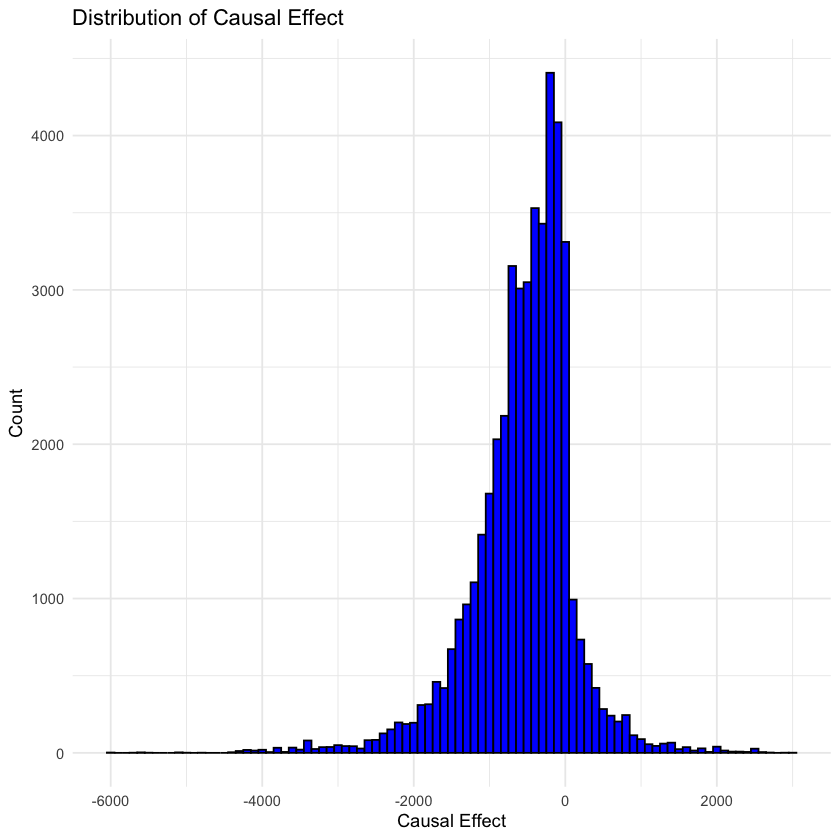

In [28]:
# Compute the average causal effect of 10,000 miles on price using XBART
xbart_predictions_plus <- colMeans(predict(xbart_model,
  test_data %>% mutate(odometer = odometer + 10000),
  n.samples = 1000
))
causal_effect <- xbart_predictions_plus - xbart_predictions
mean_causal_effect <- mean(causal_effect)
# Plot the distribution of the causal effect
print(paste("XBART Causal Effect of 10,000 miles on Price:", mean_causal_effect))
ggplot(data.frame(causal_effect = causal_effect), aes(x = causal_effect)) +
  geom_histogram(binwidth = 100, fill = "blue", color = "black") +
  labs(title = "Distribution of Causal Effect", x = "Causal Effect", y = "Count") +
  theme_minimal()